In [1]:
import tarfile
import os
import pandas as pd
from loguru import logger
from openbabel import openbabel
import rdkit.Chem as ch

In [37]:
"""path"""

WORK_DIR = os.path.curdir
DEBUG_DIR = os.path.join(WORK_DIR,'debug')
# @TODO argparse data path


"""FOR DEBUG"""
DATA_ROOT = os.path.join(DEBUG_DIR,'example')
TMP_DIR = os.path.join(DEBUG_DIR,'tmp')
if not os.path.isdir(TMP_DIR):
    os.makedirs(TMP_DIR)
OUT_DIR = os.path.join(DEBUG_DIR,'output')

"""logging"""

DEBUG = True

LOG_DIR = os.path.join(WORK_DIR,'log')
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

LOG_FILE = os.path.join(LOG_DIR,'debug_{time}.log')

logger.add(LOG_FILE,retention=2)

if DEBUG:
    logger.debug('debug data directory: {}'.format(DEBUG_DIR))

ModuleNotFoundError: No module named 'win32_setctime'

# Timing

In [2]:
import time
import contextlib

@contextlib.contextmanager
def timing(msg: str):
    logger.info('Started {}'.format(msg))
    tic = time.time()
    yield
    toc = time.time()
    logger.info('Finished %s in %.3f seconds'%(msg, toc - tic))

with timing("extract-tarfile"):
    logger.info("finished")

2022-07-03 18:57:44.702 | INFO     | __main__:timing:6 - Started extract-tarfile
2022-07-03 18:57:44.703 | INFO     | __main__:<module>:13 - finished
2022-07-03 18:57:44.703 | INFO     | __main__:timing:10 - Finished extract-tarfile in 0.000 seconds


# Tar Extractor

import tarfile

dir_1 = './debug/example/AA/'
tar_1 = os.path.join(dir_1, 'AABAAC.tar')
dir_2 = os.path.join(TMP_DIR, 'AABAAC')
tar_2_gz =  os.path.join(dir_2, '00000.tar.gz')

with  tarfile.open(tar_1) as tar:
    tar.extractall(TMP_DIR)
    names = tar.getnames()


In [22]:
from tqdm import tqdm

for d in os.listdir(DATA_ROOT):
    # d: "AA"
    d_path = os.path.join(DATA_ROOT,d)
    for f in tqdm(os.listdir(d_path)):
        # f: "AABAAC.tar"
        # if i == 2: break
        """critical section"""
        with tarfile.open(os.path.join(d_path,f)) as tf:
            names = tf.getnames()
            # name: "AABAAC/00000.tar.gz,...."
            tf.extractall(TMP_DIR)
            # to "tmp/AABAAC/00000.tar.gz"

        for name in names:
            # name: "AABAAC"
            dirname = os.path.dirname(name)
            with tarfile.open(os.path.join(TMP_DIR, name)) as tf:
                tf.extractall(os.path.join(TMP_DIR, dirname))

100%|██████████| 204/204 [00:18<00:00, 11.08it/s]


# Format Converter

In [39]:

import openbabel
def file_convert(inputFile, outputFile, inFormat='pdbqt', outFormat='sdf'):
    conv= openbabel.OBConversion("debug/tmp/AABABD/00000/Z18500480_1_T1.pdbqt", "debug/Z18500480_1_T1.smiles")
    conv.OpenInAndOutFiles("pdbqt","smiles")
    conv.Convert()
    conv.CloseOutFile()

In [20]:
input_file = "debug/tmp/AABABD/00000/Z18500480_1_T1.pdbqt"
os.path.dirname(input_file)
os.path.splitext(os.path.basename(input_file))[0]+'.smiles'

# os.path.ex

'Z18500480_1_T1.smiles'

In [12]:
import openbabel,pybel

mol = openbabel.OBMol()
a = mol.NewAtom()
a.SetAtomicNum(6)   # carbon atom
a.SetVector(0.0, 1.0, 2.0) # coordinates
b = mol.NewAtom()
mol.AddBond(1, 2, 1)   # atoms indexed from 1

pybelmol = pybel.Molecule(mol)
pybelmol.write("sdf", "outputfile.sdf")

OSError: outputfile.sdf already exists. Use 'overwrite=True' to overwrite it.

In [31]:
from concurrent import futures


def f(a, b):
    return [a**b]

"""Test for concurrent.futures"""
# if __name__ == '__main__':
with timing("parallel"):
    with futures.ProcessPoolExecutor(1) as executor:
        for i in range(100, 5000):
            future = executor.submit(f, i, i+1)
        # print(future.result())

2022-07-01 20:51:37.121 | INFO     | __main__:timing:6 - Started parallel


BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [1]:
from  data.tools import utils, converter

with utils.tmpdir_manager('./debug') as tmp_dir:
    tar_extractor = extractor.Extractor(
            data_dir='./debug/example',
            n_cpu=1)
    converter = converter.Converter(tmp_dir, 'pdbqt', 'sdf')
    tar_extractor.extract(tmp_dir)
    for d_1 in os.listdir(tmp_dir):
        logger.info(d_1)
        for d_2 in os.listdir(os.path.join(os.path.dirname(tmp_dir),d_1)):
            logger.info(d_2)
            for pdbqt_file in os.listdir(d_2):
            #     logger.info(pdbqt_file)

ModuleNotFoundError: No module named 'loguru'

# rdkit mol
指纹就是一些key的组合，输出可以是BitVect，以节省空间

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as ch
import matplotlib.pyplot as plt  # 画图

supp = Chem.SDMolSupplier('./debug/Z18500480_1_T1.sdf')
bi = {}
mols_fps_Morgen = [(m, ch.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo=bi)) for m in supp]
print(bi)


{314: ((2, 1),), 370: ((5, 2),), 475: ((0, 1),), 576: ((5, 0),), 623: ((11, 2),), 650: ((2, 0), (12, 0)), 666: ((11, 1),), 674: ((8, 0),), 738: ((5, 1),), 771: ((1, 1),), 807: ((7, 0), (11, 0)), 856: ((4, 1),), 881: ((10, 0),), 906: ((9, 1), (13, 1)), 935: ((0, 0), (3, 0)), 1037: ((4, 0), (9, 0), (13, 0)), 1102: ((10, 1),), 1145: ((6, 1),), 1199: ((6, 2),), 1209: ((8, 2),), 1263: ((1, 2),), 1370: ((10, 2),), 1380: ((1, 0), (6, 0)), 1602: ((7, 1),), 1610: ((3, 1),), 1659: ((8, 1),), 1705: ((0, 2),), 1917: ((12, 1),), 2006: ((3, 2),)}


In [16]:
mols_fps_Morgen[0][1]

In [8]:
len(mols_fps_Morgen)

1

## 一个很好用的SimilarityMap

In [88]:
from rdkit.Chem.Draw import SimilarityMaps

# 目标分子
targetmol = Chem.MolFromSmiles(
    'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
# 参考分子
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

Draw.MolDraw2DSVG(400, 400)
d.ClearDrawing()
target_mol_simi_fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(
    refmol,
    targetmol,
    lambda m, i: SimilarityMaps.GetMorganFingerprint(
        m, i, radius=2, fpType='bv'),
    draw2d=d
)
print(target_mol_simi_fig)  # Figure(250x250)
print(maxweight)  # 0.12255947497949138
d.FinishDrawing()
with open('./mol28.svg', 'w+') as outf:
    outf.write(d.GetDrawingText())
# d.ClearDrawing()

0.12255947497949138


In [5]:
from rdkit.DataStructs import ExplicitBitVect, CreateFromBinaryText
m = Chem.MolFromSmiles(
    'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
bi = {}
fp = ch.GetMorganFingerprintAsBitVect(m, radius=2)
fp = ch.GetMACCSKeysFingerprint(m)
base64 = ExplicitBitVect.ToBase64(fp)
print(base64)

# _fp = ExplicitBitVect.
_fp = ExplicitBitVect(0)
ExplicitBitVect.FromBase64(_fp, base64)

with open('./mol1','w+') as f:
    f.write(base64)
print(_fp.ToBase64())
# fp.FromBase64(base64)


4P///6cAAAA8AAAAcggEDAQGAAIAAgAGAAAAAgACAgAEAAgAAgYAAgAABAAAAAAGAgIABgACAAAABAAAAAAAAAAAAAAAAAAAAg==
4P///6cAAAA8AAAAcggEDAQGAAIAAgAGAAAAAgACAgAEAAgAAgYAAgAABAAAAAAGAgIABgACAAAABAAAAAAAAAAAAAAAAAAAAg==


In [193]:
from data.tools import utils
tmp_dir = os.path.join(os.path.curdir,'debug','tmp')
# with utils.tmpdir_manager() as tmp_dir:

for i, d_1 in enumerate(os.listdir(tmp_dir)):
    if i > 1: break
    dpath_1 = os.path.join(tmp_dir, d_1)
    for d_2 in os.listdir(dpath_1):
        dpath_2 = os.path.join(dpath_1, d_2)
        if os.path.isdir(dpath_2):
            for f in os.listdir(dpath_2):
                logger.info(os.path.join(dpath_2, f))
                logger.info(os.path.splitext(f)[0])
                # logger.debug(f)



2022-07-03 22:22:40.017 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1252751589_1_T1.pdbqt
2022-07-03 22:22:40.018 | INFO     | __main__:<module>:13 - Z1252751589_1_T1
2022-07-03 22:22:40.018 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1509950178_1_T1.pdbqt
2022-07-03 22:22:40.018 | INFO     | __main__:<module>:13 - Z1509950178_1_T1
2022-07-03 22:22:40.020 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1510155714_1_T1.pdbqt
2022-07-03 22:22:40.020 | INFO     | __main__:<module>:13 - Z1510155714_1_T1
2022-07-03 22:22:40.021 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1614339982_1_T1.pdbqt
2022-07-03 22:22:40.021 | INFO     | __main__:<module>:13 - Z1614339982_1_T1
2022-07-03 22:22:40.022 | INFO     | __main__:<module>:12 - .\debug\tmp\AABAAC\00000\Z1692816331_1_T1.pdbqt
2022-07-03 22:22:40.022 | INFO     | __main__:<module>:13 - Z1692816331_1_T1
2022-07-03 22:22:40.022 | INFO     | __main__:<module>:12 - .\debug\tmp\AAB

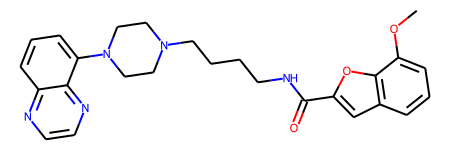

In [93]:
targetmol

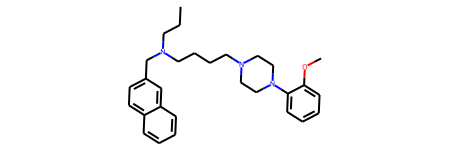

In [94]:
refmol

In [2]:
with utils.tmpdir_manager() as tmp_dir:
    tar_extractor = extractor.Extractor(
        data_dir='./debug/example',
        n_cpu=1)
    tar_extractor.extract(tmp_dir)

NameError: name 'utils' is not defined

In [12]:
full_path = './tmp6uq2a4pi/AABAAC/00000/Z1252751589_1_T1.sdf'
dirname = os.path.dirname(full_path)
basename = os.path.basename(full_path)

file_id = os.path.splitext(basename)[0]
file_id


pdbqt转fp

In [211]:
from data.tools.pipeline import  _pdbqt2fingerprint
from data.tools import pipeline

path = os.path.join('tmpycuut84t', 'AABBAC', '00000')
# out = os.path.join('tmp93eb8ia2','out')
os.makedirs('out')
for f in os.listdir(path):
    # print(f)
    file_id = os.path.splitext(f)[0]
    _pdbqt2fingerprint(path, file_id, '.sdf', 'out')

In [10]:
from meeko import PDBQTMolecule
from openbabel import openbabel

path='tmpbqzs_1_d/AABCAF/00000'
file_id = 'Z1692919946_1_T1.pdbqt'
in_full_path = os.path.join(path, file_id)
out_full_path = 'Z1692919946_1_T1.sdf'
conv = openbabel.OBConversion(in_full_path, out_full_path)
conv.OpenInAndOutFiles('.pdbqt','.smiles')
conv.Convert()
conv.CloseOutFile()

['Z1252751589_1_T1',
 'Z1509950178_1_T1',
 'Z1510155714_1_T1',
 'Z1614339982_1_T1',
 'Z1692816331_1_T1',
 'Z1692816331_2_T1',
 'Z2027307024_1_T1',
 'Z2027307024_1_T2',
 'Z2027307024_1_T3',
 'Z2499074481_1_T1',
 'Z2499074481_1_T2',
 'Z2499074481_1_T3',
 'Z2890544298_1_T1',
 'Z2890544298_2_T1',
 'Z2977592255_1_T1',
 'Z2980972959_1_T1']

In [62]:
a = os.path.splitext(os.path.join(path, file_id))[0]
os.path.basename(a)

In [80]:
os.path.basename(os.path.join(path, file_id))

'Z1692919946_1_T1'

In [78]:
from data.tools.pipeline import _cal_single_fingerprint
from openbabel import pybel
path='tmpbqzs_1_d/AABCAF/00000'
file_id = 'Z1692919946_1_T1.pdbqt'
in_full_path = os.path.join(path, file_id)
f = pybel.readfile('pdbqt',in_full_path)
mol = f.__next__()
print(mol.write("sdf", 'mol1.sdf',overwrite=True))
print(mol.write("smiles", 'mol1.smi', overwrite=True))
f.close()

# _cal_single_fingerprint(dir_path, file_id, 'smiles')

'Z1692919946_1_T1.pdbqt'

In [12]:
from rdkit import Chem
sup = Chem.SDMolSupplier("mol1.sdf")
sup = Chem.SmilesMolSupplier("mol1.smi", titleLine=1, smilesColumn=1 )
mol = sup.__next__()
mol

None
None


In [1]:
from scripts.rdkit2pdbqt import MolFromPDBQTBlock,MolToPDBQTBlock

MolToPDBQTBlock(mol)
with open("tmpbqzs_1_d/AABCAF/00000/Z1692919946_1_T1.pdbqt") as f:
    mol = MolFromPDBQTBlock(f.read())
mol

RuntimeError: File parsing error: ERROR: Index error (idx = 0): ran out of lines


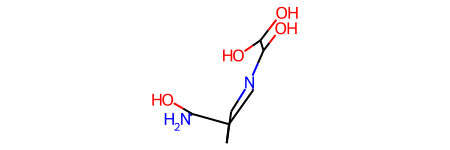

In [10]:
import os
from openbabel import pybel
from rdkit import Chem

f = pybel.readfile('smiles','mo2.smiles')
smi_str = f.__next__().write().split('\t')[0]
mol = Chem.MolFromSmiles(smi_str)

base64 = mol
# base64[0]
base64

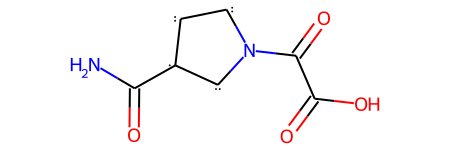

In [14]:
# smi_str
Chem.SmilesMolSupplierFromText('CO')


那么上面这段就说明，pybel造的格式只有自己看得懂，SmilesMolSupplier看不懂，那么就用pybel的read，然后转为smiles字符串读取。
2022年7月8日15:19:25 smiles转换失败率太高了...

删除output

In [ ]:
import shutil

out_dir = './debug/output'
shutil.rmtree(out_dir, ignore_errors=True)

下面这几段，发现有些没转化成功的就是因为坐标重合了，或者是直接是空的
3w个里有差不多30个左右吧

In [37]:
import  glob
import pandas as pd
df_fp = pd.DataFrame([os.path.splitext(os.path.basename(i))[0] for i in glob.glob('./debug/output/*.fp')])
df_pdbqt = pd.DataFrame([os.path.splitext(os.path.basename(i))[0] for i in glob.glob(r'./tmp626uhmgx/**/*.pdbqt', recursive=True)])

In [60]:
df_fp.head()
df_pdbqt.head()
df_error = df_pdbqt.append(pd.DataFrame.merge(df_fp, df_pdbqt)).drop_duplicates(keep=False).reset_index(drop=True)
# for i in df_error[0
# ]:
paths = []
for i in df_error[0]:
    paths.extend(glob.glob(r'./tmp626uhmgx/**/{}.pdbqt'.format(i), recursive=True))
for path in paths:
    with open(path, 'r') as f:
        print(f.read())


REMARK    Small molecule (ligand)
REMARK    Compound: Z2916152125_3_T1
REMARK    SMILES: CN1C[C@@H]2CC[C@@H](C1)N2C(=O)C(N)=O
REMARK    The ligand was originally not a salt, therefore no desalting was carried out.
REMARK    The tautomeric state was generated by cxcalc version 18.20.0 of ChemAxons JChem Suite.
REMARK    Protonation state was generated at pH 7.4 by cxcalc version 18.20.0 of ChemAxons JChem Suite.
REMARK    Generation of the 3D conformation was carried out by Open Babel version 2.4.1
REMARK    Generation of the the target format file (pdbqt) was carried out by Open Babel version 2.4.1.
REMARK    Created on Sun Nov  4 17:42:55 EST 2018
REMARK  4 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: _1  and  _2
REMARK    2  A    between atoms: _11  and  _12
REMARK    3  A    between atoms: _12  and  _14
REMARK    4  A    between atoms: _14  and  _15
REMARK                            x       y       z     vdW  Elec       q    T

In [61]:
paths

['./tmp626uhmgx\\AABBAC\\00000\\Z2499112464_1_T1.pdbqt',
 './tmp626uhmgx\\AABBAD\\00000\\Z2916152125_3_T1.pdbqt',
 './tmp626uhmgx\\AABCAD\\00000\\Z2173929911_2_T1.pdbqt',
 './tmp626uhmgx\\AABCAD\\00000\\Z2920307585_2_T1.pdbqt',
 './tmp626uhmgx\\AABCAE\\00000\\Z2801459431_4_T1.pdbqt',
 './tmp626uhmgx\\AABCAE\\00000\\Z3137795513_1_T1.pdbqt',
 './tmp626uhmgx\\AABCBC\\00000\\Z2772959294_3_T1.pdbqt',
 './tmp626uhmgx\\AABCBC\\00000\\Z2843053941_2_T1.pdbqt',
 './tmp626uhmgx\\AABCBD\\00001\\Z2843053632_6_T1.pdbqt',
 './tmp626uhmgx\\AABDBC\\00000\\Z2827197829_8_T1.pdbqt',
 './tmp626uhmgx\\AABDBD\\00000\\Z2726614023_1_T1.pdbqt',
 './tmp626uhmgx\\AABDBD\\00000\\Z2995999308_7_T1.pdbqt',
 './tmp626uhmgx\\AABDCE\\00000\\Z2711168684_1_T1.pdbqt',
 './tmp626uhmgx\\AABDCE\\00000\\Z2711168684_2_T1.pdbqt',
 './tmp626uhmgx\\AABDCE\\00000\\Z2712630551_1_T1.pdbqt',
 './tmp626uhmgx\\AACBAD\\00000\\Z2827237594_8_T1.pdbqt',
 './tmp626uhmgx\\AACBAD\\00000\\Z2827237605_4_T1.pdbqt',
 './tmp626uhmgx\\AACCAE\\00000\